# Gaussian mixture model

In Gaussian mixture model, we place a strong condition on the distribution of the data: we assume that the data comes from a mixture of $k$ multivariate Gaussian model. Our goal is, given unlabeled data, assign each point to its original cluster. Formally, let $t$ be the label, we assume that the $p(x|t=i)=\mathcal{N}(x;\mu_i, \Sigma_i)$, the probability distribution of the data is then given by 

$$p(x)=\sum_{i=1}^k p(t=i)p(x|t=i) = \sum_{i=1}^k \pi_i \mathcal{N}(x;\mu_i, \Sigma_i)$$

Where we defined $\pi_i=p(t=i)$. Note that if the parameters $\pi_i, \mu_i, \Sigma_i$ is known, then clustering becomes a trivial task, we simply assign $x$ to the class

$$k^* = \underset{i}{\text{argmax}} \;p(t=i|x) = \underset{i}{\text{argmax}} \;p(x|t=i)p(t=i) = \underset{i}{\text{argmax}} \; \pi_i \mathcal{N}(x;\mu_i, \Sigma_i)$$

Therefore, it suffice estimating the parameters in this case. We can estimate the parameters using maximum likelihood. Given data $\{x_i\}$, the log-likelihood is given by

$$l(\theta) = \log p(x_1, x_2,..., x_n) = \sum_{i=1}^n \log p(x_i) = \sum_{i=1}^n \log \bigg( \sum_{i=1}^k \pi_i \mathcal{N}(x;\mu_i, \Sigma_i) \bigg)$$

We can certainly optimize the above expression using gradient descent. In practice, however, another algorithm, called the expectation maximization (EM) algorithm, is more frequently used. The EM algorithm, like gradient descent, solves the MLE in an iterative manner. It is however more efficient. 

## Expectation maximization

Expectation maximization algorithm essentially is a generalization of the kMeans algorithm. Recall that kMeans involves two steps

1. Assign: Assign each data point to its cluster based on certroid distances
2. Recompute: Recompute parameters (centroids).

It turns out that we can solve the Gaussian mixture model following the same structure

1. Assign: Assign each data point to its cluster based on maximizing posterior
2. Recompute: Recompute parameters $\pi_i, \mu_i,\Sigma_i$.

In EM algorithm, the assign step is called the expectation (E) step, and the recompute step is called the maximization (M) step. We will discuss the reasons in the next section. We can derive the algorithm by considering the gradient of the log-likelihood, the first order condition is given by

$$\frac{\partial l}{\partial \pi_i} = -\sum_{n=1}^N \frac{\pi_i \mathcal{N}(x_n;\mu_i, \Sigma_i)}{\sum_{j}  \pi_j \mathcal{N}(x_n;\mu_j, \Sigma_j)}\Sigma_i (x_n-\mu_i)=0$$

Note that the term 

$$p_{i,n} = \frac{\pi_i \mathcal{N}(x_n;\mu_i, \Sigma_i)}{\sum_{j}  \pi_j \mathcal{N}(x_n;\mu_j, \Sigma_j)}$$

Essentially is the posterior distribution $p_{i,n}=p(t=i|X=x_n)$. Use the notation, we have

$$\sum_{n=1}^N p_{i, n}\Sigma_i (x_n-\mu_i)=0$$

Assuming that $\Sigma_i$ is non-singular, multiplying both sides by its inverse and rearranging gives us

$$\mu_i = \frac{1}{N_i}\sum_{n=1}^N p_{i, n} x_n\hspace{5mm}\text{where}\;N_i = \sum_{j=1}^n p_{i, n}$$

By the same line of reasoning, we have

$$\Sigma_i = \frac{1}{N_i}\sum_{n=1}^N p_{i, n} (x_n - \mu_i)(x_n-\mu_i)^T$$

And 

$$\pi_i = \frac{N_i}{N}$$

Therefore, we see that the optimum of the MLE is characterized by 

$$\begin{equation*}
\begin{cases}
\mu_i = \frac{1}{N_i}\sum_{n=1}^N p_{i, n} x_n\\
\Sigma_i = \frac{1}{N_i}\sum_{n=1}^N p_{i, n} (x_n - \mu_i)(x_n-\mu_i)^T\\
\pi_i = \frac{N_i}{N}
\end{cases}
\end{equation*}
$$

This, however, is not a closed form solution, as the posterior $p_{i, n}$ also depends on $\mu_i, \Sigma_i$. This, however, does offer motivation to an iterative algorithm as suggest by before: we first assign classes based on posterior, then update parameters using the equations above. Note that in the above expression, $\mu_i, \Sigma_i$ is essentially the same as the MLE estimator for Gaussian, expect that the number of samples used to find the $i$th Gaussian are the points previously assigned to cluster $i$.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse

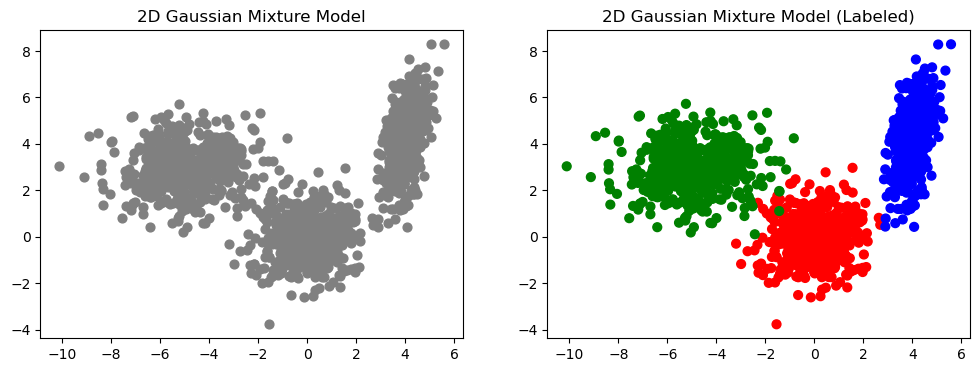

In [100]:
n_samples = 500

mean1 = [0, 0]
cov1 = [[1, 0.1], [0.1, 1]]
x1 = np.random.multivariate_normal(mean1, cov1, n_samples)
y1 = np.full((n_samples, ), 0)

mean2 = [4, 4]
cov2 = [[0.2, 0.3], [0.3, 2]]
x2 = np.random.multivariate_normal(mean2, cov2, n_samples)
y2 = np.full((n_samples, ), 1)

mean3 = [-5, 3]
cov3 = [[2, 0.1], [0.1, 1]]
x3 = np.random.multivariate_normal(mean3, cov3, n_samples)
y3 = np.full((n_samples, ), 2)
X = np.vstack((x1, x2, x3))
y = np.concatenate((y1, y2, y3))

colors = ["red", "blue", "green"]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].scatter(X[:, 0], X[:, 1], c="gray", s=40)
ax[0].set_title('2D Gaussian Mixture Model')
ax[1].scatter(X[:, 0], X[:, 1], c=[colors[int(i)] for i in y], s=40)
ax[1].set_title('2D Gaussian Mixture Model (Labeled)')
plt.show()

In [154]:
class GaussianMixtureModel:
    
    def __init__(self, k, d):
        self.k = k
        self.mu = np.random.randn(k, d)
        self.sigma = np.array([np.eye(d) for _ in range(k)])
        self.pi = np.ones(k) / k
        self.eps = 1e-6
    
    def fit(self, X, n_epochs=10):
        n, d = X.shape
        for epoch in range(n_epochs):
            post = self.posterior(X)
            Nk = post.sum(axis=0) 
            self.mu = np.dot(post.T, X) / Nk[:, np.newaxis]
            for i in range(self.k):
                diff = X - self.mu[i]
                self.sigma[i] = np.dot(post[:, i] * diff.T, diff) / Nk[i] + self.eps * np.eye(d) 
            self.pi = Nk / n

    def posterior(self, X):
        n, d = X.shape
        posterior = np.zeros((n, self.k))
        for i in range(self.k):
            likelihood = multivariate_normal.pdf(X, mean=self.mu[i], cov=self.sigma[i])
            posterior[:, i] = self.pi[i] * likelihood
        posterior /= posterior.sum(axis=1, keepdims=True)
        return posterior

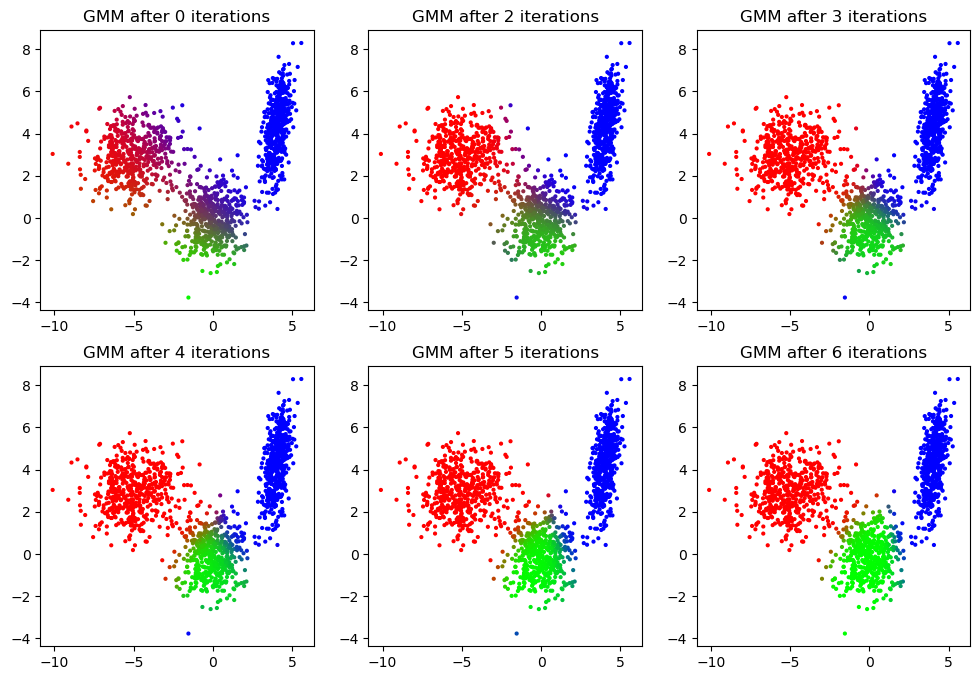

In [173]:
gmm = GaussianMixtureModel(3, 2)

colors = np.array([[1, 0, 0], [0, 0, 1], [0, 1, 0]]) 
epochs = [0, 2, 1, 1, 1, 1]
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax = ax.flatten()
for i in range(6):
    gmm.fit(X, n_epochs=epochs[i])
    post = gmm.posterior(X)
    ax[i].scatter(X[:, 0], X[:, 1], c=np.dot(post, colors), s=4)
    ax[i].set_title(f"GMM after {sum(epochs[:i+1])} iterations")

## Relation to kMeans

Based on the same structure of the algorithm, it is not suprising to see that Gaussian of mixture model is related to kMeans. In fact, in the next section, we will see that they both belong to a special case of generalized EM algorithm. In this section, we first show that kMeans can be treated as a extreme case of GMM. <br>

Consider Gaussian mixture model with $k$ classes, we assume that the $k$ classes follows the distribution of $\mathcal{N}(x;\mu_i, \sigma^2 I)$. Note that we've fixed the covariance matirx. Note that in the E step, we assign clusters based on posterior

$$
\begin{align*}
p(t=i|x) &= \frac{\pi_i \mathcal{N}(x;\mu_i, \sigma^2 I)}{\sum_{j}  \pi_j \mathcal{N}(x;\mu_j, \sigma^2 I)}\\
&\propto \pi_i \exp(-\frac{||x-\mu_i||_2^2}{2\sigma^2})
\end{align*}$$

If we take $\sigma\rightarrow 0$, then the posterior is maximized for cluster whose $||x-\mu_i||$ is the smallest. In this case, we see that the E step reduces to assigning classes based on smallest centroid distance. The M step then reduces back to the ones for kMeans. From this persepctive, we can treat kMeans as a special case of GMM where the variance $\sigma^2$ is $0$. GMM assigns soft labeling while kMeans assigns hard labels. 